In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
import utils

from PIL import Image as pil_image

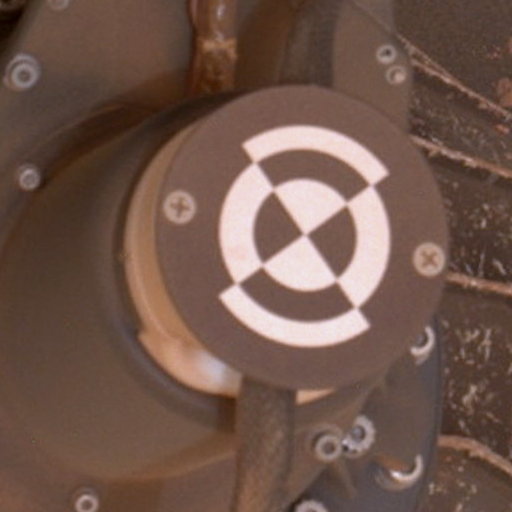

In [2]:
image = pil_image.open("input/marker_cut_rgb_512.png")
image

## FAST corner detector 

In [3]:
# Process image as numpy array
image_numpy = np.array(image)

In [4]:
def show(im):
    # Plots numpy array as pil image
    return pil_image.fromarray(im.astype(np.uint8))

### 1. Gaussian filter
A Gaussian filter is applied to the image to remove noise. 

In [5]:
def gauss_pdf(sigma, x, y):
    return np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)


def gauss_filter(sigma, size=5):
    kernel = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            kernel[i, j] = gauss_pdf(sigma, i - size // 2, j - size // 2)

    return kernel / np.sum(kernel)

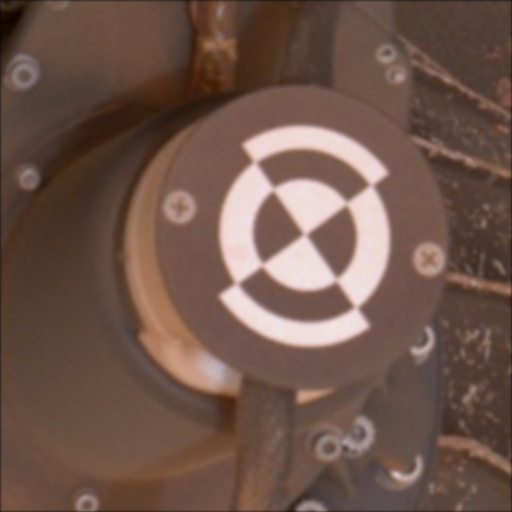

In [6]:
f = gauss_filter(1.4, 9)

image_smoothed = utils.convolve_image(image_numpy, f)
show(image_smoothed)

### Convert image to grayscale

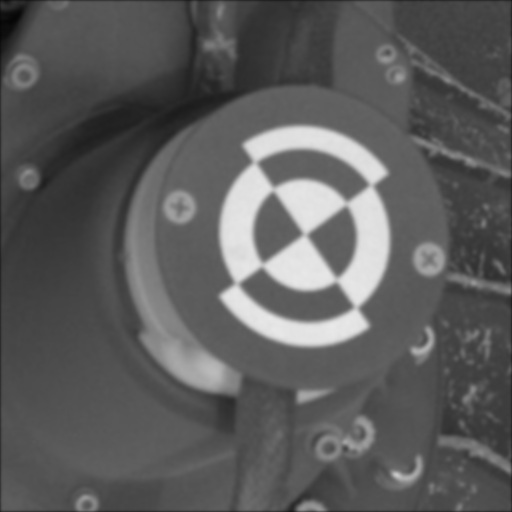

In [7]:
def rgb_to_gray(im):
    return 0.3 * im[:, :, 0] + 0.59 * im[:, :, 1] + 0.11 * im[:, :, 2]


image_grayscaled = rgb_to_gray(image_smoothed)
show(image_grayscaled)

###  Bresenham circle
FAST corner detector uses a circle of 16 pixels (a Bresenham circle of radius 3) to classify whether a candidate point p is actually a corner. Each pixel in the circle is labeled from integer number 1 to 16 clockwise.

In [8]:
def get_bresenham_cirle(im, i, j):
    return [
        im[i, j - 3],
        im[i + 1, j - 3],
        im[i + 2, j - 2],
        im[i + 3, j - 1],
        im[i + 3, j],
        im[i + 3, j + 1],
        im[i + 2, j + 2],
        im[i + 1, j + 3],
        im[i, j + 3],
        im[i - 1, j + 3],
        im[i - 2, j + 2],
        im[i - 3, j + 1],
        im[i - 3, j],
        im[i - 3, j - 1],
        im[i - 2, j - 2],
        im[i - 1, j - 3],
    ]

### High-speed test
A high-speed test was proposed to exclude a large number of non-corners. This test examines only the four pixels at 1, 9, 5 and 13 (First 1 and 9 are tested if they are too brighter or darker. If so, then checks 5 and 13). If $p$ is a corner, then at least three of these must all be brighter than $I_p + t$ or darker than $I_p − t$. If neither of these is the case, then p cannot be a corner.

In [9]:
def is_corner_candidate(im, i, j, t):
    p = im[i, j]
    # Pixels 1,5,9 and 13
    pixels = im[i, j - 3], im[i + 3, j], im[i, j + 3], im[i - 3, j]

    # Check that at least 3 of 4 pixels are brighter or darker than p
    if sum([pixel > p + t for pixel in pixels]) >= 3:
        return True, True

    if sum([pixel < p - t for pixel in pixels]) >= 3:
        return True, False
    # High speed corner test failed. This pixel is not a corner
    return False, None

### Corner score
For non-maximum suppression we calculate every possible corner's score.
Corner's score - is a sum of pixels which are all darker or brighter than keypoint

In [10]:
def get_corner_score(im, i, j, threshold, is_brighter):
    # p is corner if there exists 12 contiguous pixels in the circle
    # that are all darker or brighter than p +- threshold
    p = im[i, j]
    if is_brighter:
        # Pixel > p+t
        pixels_score = [
            pixel - p - threshold for pixel in get_bresenham_cirle(im, i, j)
        ]
    else:
        # pixel < p-t
        pixels_score = [
            p - threshold - pixel for pixel in get_bresenham_cirle(im, i, j)
        ]

    max_contiguous_pixels = 0
    current_contiguous_pixels = 0
    for pixel in pixels_score * 2:
        current_contiguous_pixels = current_contiguous_pixels + 1 if pixel > 0 else 0
        if current_contiguous_pixels > max_contiguous_pixels:
            max_contiguous_pixels = current_contiguous_pixels

    pixels_score = np.array(pixels_score)
    return (max_contiguous_pixels, np.sum(pixels_score[pixels_score > 0]))

#### Select a pixel $p$ in the image which is to be identified as an interest point or not. Let its intensity be $I_p$.  Now the pixel p is a corner if there exists a set of n contiguous pixels in the circle (of 16 pixels) which are all brighter than $I_p + t$, or all darker than $I_p − t$. n was chosen to be 10

In [11]:
def segment_test_detector(im, threshold=20):
    height, width = im.shape
    corners = np.zeros(im.shape)

    for i in range(3, width - 3):
        for j in range(3, height - 3):
            is_candidate, is_brighter = is_corner_candidate(im, i, j, threshold)

            if is_candidate:
                max_contiguous_pixels, corner_score = get_corner_score(
                    im, i, j, threshold, is_brighter
                )
                if max_contiguous_pixels >= 10:
                    corners[i, j] = corner_score
    return corners


corners = segment_test_detector(image_grayscaled, 13)

#### Visualize found segments

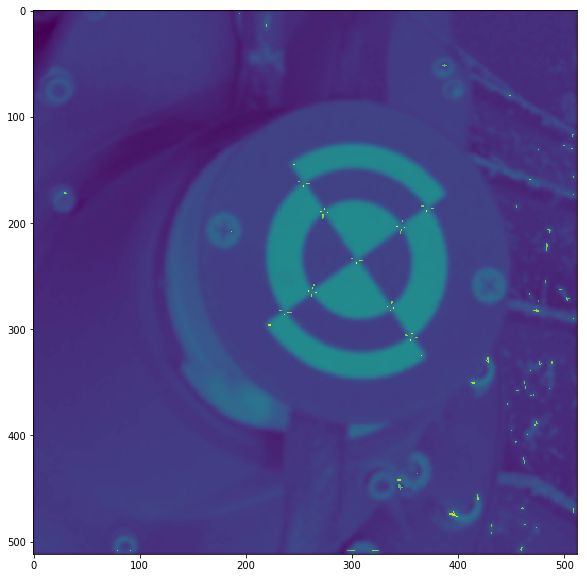

In [12]:
ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(10, 10)
ax.imshow(image_grayscaled + 255 * np.ceil(corners / corners.max()))

### Non-maximum suppression
Detecting multiple interest points in adjacent locations is another problem. It is solved by using Non-maximum Suppression.

Compute a score function, V for all the detected feature points. V is the sum of absolute difference between p and 16 surrounding pixels values.
Consider two adjacent keypoints and compute their V values.
Discard the one with lower V value.


In [13]:
def non_maximum_suppresion(im, size=5):
    height, width = im.shape
    im_padded = utils.zero_padding(im.reshape(im.shape + (1,)), size // 2)
    result = np.zeros(im.shape)

    for i in range(width):
        for j in range(height):
            maximum_score = im_padded[i : i + size, j : j + size].max()
            if maximum_score and maximum_score == im[i, j]:
                result[i, j] = 1
    return result


corners = non_maximum_suppresion(corners, 12)

#### Visualize NMS

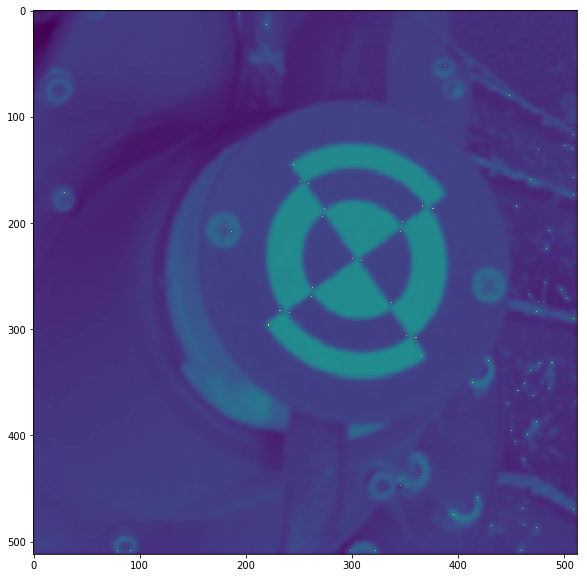

In [14]:
ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(10, 10)
ax.imshow(image_grayscaled + 255 * corners)

### Create FAST pipeline

In [15]:
def get_fast_corners(im):
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    f = gauss_filter(1, 5)
    smoothed = utils.convolve_image(im, f)

    if smoothed.shape[2] == 3:
        # Convert rgb to grayscale
        grayscaled = rgb_to_gray(smoothed)
    else:
        # Set two dimensions
        grayscaled = smoothed.reshape(smoothed.shape[0], smoothed.shape[1])

    threshold = 13
    all_corners = segment_test_detector(grayscaled, threshold)
    suppressed_corners = non_maximum_suppresion(all_corners, 5)

    return suppressed_corners

## BRIEF (Binary Robust Independent Elementary Features) descriptor

### To build a BRIEF descriptor of length n, we need to determine n pairs (Xi,Yi)

In [16]:
def get_n_pairs(n, patch_size):
    # Set seed to get the same points each time
    np.random.seed(0)
    pairs = set()
    while len(pairs) < n:
        x, y = np.random.randint(0, patch_size, 2)
        if x == patch_size // 2 and y == patch_size // 2:
            # Exclude keypoint from pairs
            continue
        pairs.add((x, y))

    return list(pairs)

#### To build the binary string representing of the region around a keypoint we need to go over all the pairs and for each pair (p1,p2) – if the intensity at point p1 is greater than the intensity at point p2, we write 1 in the binary string and 0 otherwise.

In [17]:
def brief(im, p_x, p_y, pairs, patch_size=49):
    if len(pairs) >= patch_size ** 2:
        # Selected pairs number cannot exceed total number of pairs in patch
        return None
    height, width = im.shape
    half_patch_size = patch_size // 2

    if (
        p_x < half_patch_size
        or p_y < half_patch_size
        or p_x >= width - half_patch_size
        or p_y >= height - half_patch_size
    ):
        # Invalid keypoint. Patch overflows image.
        return None

    # Get keypoint value
    p = im[p_x, p_y]
    descriptor = [0] * len(pairs)

    for index, (pair_x, pair_y) in enumerate(pairs):
        point_value = im[p_x - half_patch_size + pair_x, p_y - half_patch_size + pair_y]
        descriptor[index] = "1" if point_value > p else "0"

    return "".join(descriptor)

#### Use Hamming Distance to match descriptors.

In [18]:
def hamming_distance(a, b):
    return sum(i != j for i, j in zip(a, b))

## Demo part
### Test FAST corner detector and BRIEF descriptor

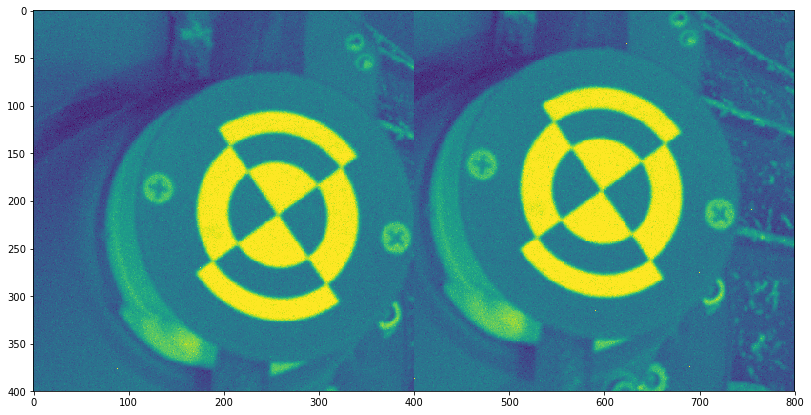

In [19]:
test_image_1 = np.array(pil_image.open("input/translation_noise_4.png"))
test_image_2 = np.array(pil_image.open("input/translation_noise_9.png"))

plt.gcf().set_size_inches(14, 7)
plt.imshow(np.hstack((test_image_1, test_image_2)));

#### Find corners

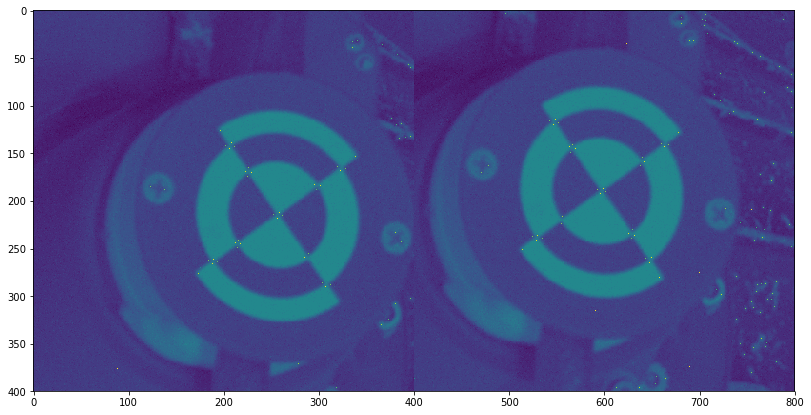

In [20]:
corners_1 = get_fast_corners(test_image_1)
corners_2 = get_fast_corners(test_image_2)

plt.gcf().set_size_inches(14, 7)
plt.imshow(np.hstack((test_image_1 + corners_1 * 255, test_image_2 + corners_2 * 255)));

#### Calculate descriptors for each keypoint

In [21]:
patch_size = 49
descriptor_length = 256
# Initialize pairs for brief descriptor
pairs = get_n_pairs(descriptor_length, patch_size)

# Save indexes of corners
image_1_keypoints = list(zip(*np.where(corners_1 > 0)))
image_2_keypoints = list(zip(*np.where(corners_2 > 0)))


image_1_kp_descriptors = []
for kp in image_1_keypoints:
    descriptor = brief(test_image_1, kp[0], kp[1], pairs)
    # If keypoint is not valid - brief returns None
    if descriptor is not None:
        image_1_kp_descriptors.append((kp, descriptor))

image_2_kp_descriptors = []
for kp in image_2_keypoints:
    descriptor = brief(test_image_2, kp[0], kp[1], pairs)
    if descriptor is not None:
        image_2_kp_descriptors.append((kp, descriptor))

### Match keypoints with nearest descriptors

In [22]:
matches = []

for kp, descriptor1 in image_1_kp_descriptors:
    distances = [
        hamming_distance(descriptor1, descriptor2)
        for _, descriptor2 in image_2_kp_descriptors
    ]
    if np.min(distances) < 35:
        nearest_kp = image_2_kp_descriptors[np.argmin(distances)][0]
        matches.append((kp, nearest_kp))

### Visualize matched descriptors

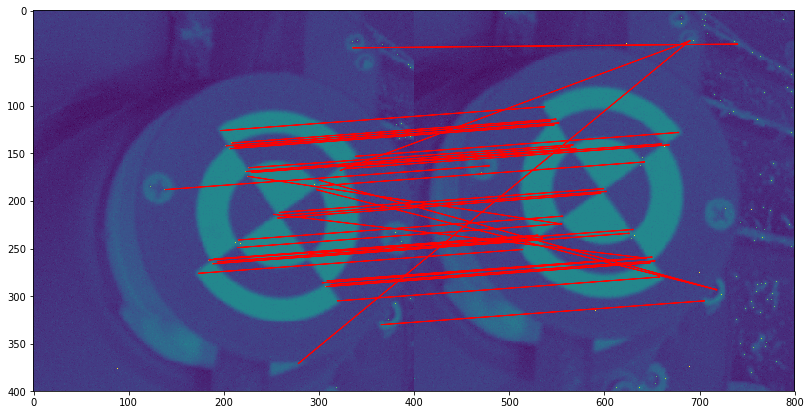

In [23]:
for kp1, kp2 in matches:
    y, x = kp1
    dx = test_image_1.shape[0] + kp2[1] - x
    dy = kp2[0] - y
    plt.arrow(x, y, dx, dy, width=0.01, color="red", head_width=1)

plt.gcf().set_size_inches(14, 7)
plt.imshow(np.hstack((test_image_1 + corners_1 * 255, test_image_2 + corners_2 * 255)))